# 0. Introduction 

In March of 2017, a very nice guy I play D&D with told me that he traded cryptocurrencies. I asked him about his performance, and he said, "I have only ever made money."

There are a few ways to interpret my friend's success. 
On one hand, he could be an excellent trader, who can consistently spot market trends due to his analytical abilities and domain knowledge.
Statistically, however, my friend is more likely to be a mediocre trader than a great one.
And all traders, even excellent ones, sometimes lose.

Another explanation for his success, then, is that the market for cryptocurrencies is generally good.

### Establishing a hot market with buy-and-hold
In this notebook, I verify that the cryptocurrency market is indeed generally good. Specifically, I show that a diversified portfolio of cryptocurrencies, with a buy-and-hold (non-)trading strategy, would have performed very well over the past year (a period for which we have high-resolution trading data).

### Optimizing on a simple strategy (PeakRider)
Next, I introduce an optimized buy-and-hold strategy. As you will observe in the following notebooks, coins will often spike in value, and then crash. These spikes cause some coins to exert a relatively large influence over our portfolio's overall value. 
- Whenever we detect that our holdings of a coin are "buffed" (high in relative value), we check its historical data to see if it is currently crashing. 
- If a holding is both buffed and crashing, we sell some of it, such that the value of our remaining holdings are equal to the median value of our overall holdings.
- After selling this crashing asset, we take the gains earned and distribute them equally among the remainder of the coins in our portfolio.

Join me for the ride.

# 1. A corpus of trading data

For simulating our portfolio strategies, we will use a historical corpus of data collected from Poloniex, a popular cryptocurrency exchange with a robust API.
(Refer to `corpus-collection.ipynb` for more on how this was collected).

In [1]:
%pylab inline
import pandas as pd
def load (csv):
    return pd.read_csv(csv, parse_dates=[0], index_col=0)
    
aligned = load('aligned-historical-prices-poloniex.csv')
aligned.head()

Populating the interactive namespace from numpy and matplotlib


weightedAverage  weightedAverage.1  weightedAverage.2  \
2016-04-20 14:45:00         0.000043       8.000000e-08           0.000002   
2016-04-20 15:00:00         0.000043       8.000000e-08           0.000002   
2016-04-20 15:15:00         0.000043       8.000000e-08           0.000002   
2016-04-20 15:30:00         0.000043       8.000000e-08           0.000002   
2016-04-20 15:45:00         0.000043       8.000000e-08           0.000002   

                     weightedAverage.3  weightedAverage.4  weightedAverage.5  \
2016-04-20 14:45:00           0.000008           0.000068           0.002237   
2016-04-20 15:00:00           0.000008           0.000068           0.002237   
2016-04-20 15:15:00           0.000008           0.000068           0.002237   
2016-04-20 15:30:00           0.000008           0.000068           0.002237   
2016-04-20 15:45:00           0.000008           0.000068           0.002237   

                     weightedAverage.6  weightedAverage.7  weightedAverage.8  \
2016-04-20 14:45:00           0.000106           0.000011       5.100000e-07   
2016-04-20 15:00:00           0.000105           0.000011       5.100000e-07   
2016-04-20 15:15:00           0.000105           0.000011       5.100000e-07   
2016-04-20 15:30:00           0.000105           0.000011       5.100000e-07   
2016-04-20 15:45:00           0.000105           0.000011       5.100000e-07   

                     weightedAverage.9                ...                 \
2016-04-20 14:45:00           0.000001                ...                  
2016-04-20 15:00:00           0.000001                ...                  
2016-04-20 15:15:00           0.000001                ...                  
2016-04-20 15:30:00           0.000001                ...                  
2016-04-20 15:45:00           0.000001                ...                  

                     weightedAverage1492724620.5810502  \
2016-04-20 14:45:00                                NaN   
2016-04-20 15:00:00                                NaN   
2016-04-20 15:15:00                                NaN   
2016-04-20 15:30:00                                NaN   
2016-04-20 15:45:00                                NaN   

                     weightedAverage1492724620.598718  \
2016-04-20 14:45:00                               NaN   
2016-04-20 15:00:00                               NaN   
2016-04-20 15:15:00                               NaN   
2016-04-20 15:30:00                               NaN   
2016-04-20 15:45:00                               NaN   

                     weightedAverage1492724620.618281  \
2016-04-20 14:45:00                               NaN   
2016-04-20 15:00:00                               NaN   
2016-04-20 15:15:00                               NaN   
2016-04-20 15:30:00                               NaN   
2016-04-20 15:45:00                               NaN   

                     weightedAverage1492724620.634254  \
2016-04-20 14:45:00                               NaN   
2016-04-20 15:00:00                               NaN   
2016-04-20 15:15:00                               NaN   
2016-04-20 15:30:00                               NaN   
2016-04-20 15:45:00                               NaN   

                     weightedAverage1492724620.65153  \
2016-04-20 14:45:00                              NaN   
2016-04-20 15:00:00                              NaN   
2016-04-20 15:15:00                              NaN   
2016-04-20 15:30:00                              NaN   
2016-04-20 15:45:00                              NaN   

                     weightedAverage1492724620.672846  \
2016-04-20 14:45:00                               NaN   
2016-04-20 15:00:00                               NaN   
2016-04-20 15:15:00                               NaN   
2016-04-20 15:30:00                               NaN   
2016-04-20 15:45:00                               NaN   

                     weightedAverage1492724620.6915042  \
2016-04-20 14:45:

Each column represents the price, in BTC, of each coin on Poloniex's exchange at every 15-minute period since 4-20-2016.

Note that some values are `NaN` at the beginning. Those `NaN`s represent times before the currency was traded on Poloniex.

Now we'll create 16-week slices of the data set, each slice starting 1 week apart from the one prior. 

(Yes, the slices overlap with one another. This is good - we never know when we will start "watching" a market, and don't want our slices to consistently line up with calendar events (like periods in fiscal quarters).

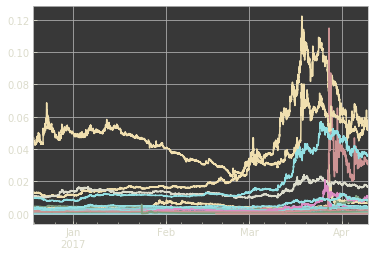

In [2]:
def timeslices (aligned_prices, weeks_apart=2, week_dur=16):
    global_start = aligned_prices.index[0]
    global_end   = aligned_prices.index[-1] - pd.Timedelta(weeks=week_dur)
    freq_str = '{!s}W'.format(weeks_apart)
    range_starts = pd.date_range(global_start, global_end, freq=freq_str)
    range_ends   = [range_start + pd.Timedelta(weeks=week_dur) 
                    for range_start in range_starts]
    slices =   [aligned_prices[(aligned_prices.index >= start)
                             & (aligned_prices.index < end)]
                 for start, end in zip(range_starts, range_ends)]
    return slices

slices_15m = timeslices(aligned, weeks_apart=2, week_dur=16)
slices_15m[-1].plot(legend=False)

To make our computes a little quicker while we're testing, let's resample this by daily means.
(We'll come back to the higher-resolution data later).


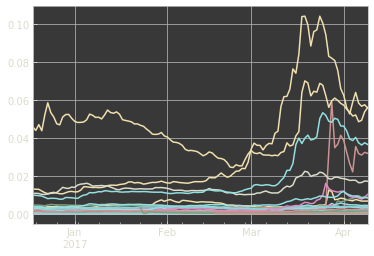

In [3]:
resample = lambda slices, dur: [s.resample(dur).mean() for s in slices]
slices_1d = resample(slices_15m, '1d')
slices_1d[-1].plot(legend=False)

# 2. Testing a diversified buy-and-hold

As mentioned above, we are testing the hypothesis that the market for cryptocurrencies is generally hot. 

If this is the case, a buy-and-hold across a diversified portfolio of cryptocurrencies would be expected to perform well.

We'll star twith the simplest thing that could possibly work:

- We will take some budget (say 1 BTC).
- We will divide this sum evenly across all coins we wish to buy. So, at inception, our portfolio will have an equal value (in BTC worth) of every coin.
- We will simply hold onto all our assets until the end of the 16-week trading period.


In [4]:
def reduce_over_time (fn, df):
    '''
    
    `df` is a DataFrame of historical prices.
    We go through `df` row by row, applying `fn` to it.
    
    `fn` is a method that takes (cur_prices, holdings, capital) and returns a value.
    `cur_prices` is the current row of historical prices.
    `holdings` is a row of the same size as `cur_prices`, representing the number of coins held as of the prior step. 
    It is one of the accumulators of our reduce.
    `capital` is a float, representing the amount of capital invested to date.
    It is the other accumulator of our reduce.
    
    `fn` should return `holding`, `capital`.

    On the first row (when there is no previous row), it will call

       fn(cur_row, None, 0)

    That way, the returned DataFrame is the same number of rows as the input DataFrame.
    Additionally, the returned DataFrame will have the same index as `df`,
    so the two can be merged, concatenated, what-have-you.
    '''
    historical_holdings = []
    historical_capital = []
    for i, idx_row in enumerate(df.iterrows()):
        idx, row = idx_row
        cur = df.iloc[i]
        if i == 0:
            new_holdings, cap_down = fn(cur, None, 0)
        else:
            prev_hold = historical_holdings[i-1]
            prev_cap = historical_capital[i-1]
            new_holdings, cap_down = fn(cur, prev_hold, prev_cap)
        historical_holdings.append(new_holdings)
        historical_capital.append(cap_down)
    holdings_df = pd.DataFrame(historical_holdings)
    cap_down_df = pd.DataFrame(historical_capital)
    holdings_df.index = df.index
    cap_down_df.index = df.index
    return holdings_df, cap_down_df

def nans (length):
    a = np.zeros(length)
    a.fill(np.nan)
    return a

def mult (df, df2):
    return pd.DataFrame(df.values*df2.values, columns=df.columns, index=df.index)

In [5]:
from copy import copy
from functools import partial

def buy_and_hold (starting_investment, prices, holdings, capital_down,
                 rebalancer=None):
    # the accumulator is the size of dataframe -
    # each col will represent our holdings at each time
    # plus an additional column for "capital put down"
    acc_len = len(prices)
    # initial acc value, if there is no acc yet
    if holdings is None:
        holdings = nans(acc_len)
    # for each price in the row
    cap_down_this_turn = 0
    
    # let's assume we've already seen this currency -
    # in which that holding is staying as it was
    new_holdings = copy(holdings)
    
    # We'll come back to this later, just ignore it for now
    if rebalancer:
        new_holdings = rebalancer(prices, holdings)
        
    for i, price in enumerate(prices):
        # if  we've never seen this price before,
        if (not np.isnan(prices[i])) and (np.isnan(holdings[i])):
            # buy however much our initial investment gets us
            quantity = starting_investment / price
            new_holdings[i] = quantity
            # and record our capital investment in the final row of the acc
            cap_down_this_turn += starting_investment
    # update our total capital investment
    # Return this row of holdings.
    return new_holdings, capital_down+cap_down_this_turn

def backtest (strategy, aligned_daily_prices,
              debug=False, budget=1,  **kwargs):
    cap_down_per_new_coin = budget / len(aligned_daily_prices.columns)
    strat = partial(strategy, cap_down_per_new_coin, **kwargs)
    # our holdings of each currency, on any given day
    holdings, capital_down = reduce_over_time(strat, aligned_daily_prices)
    # the value of our holdings for each currency, on any given day
    aligned_daily_prices = aligned_daily_prices.fillna(0)
    values = mult(holdings, aligned_daily_prices)
    # our portfolio's value, at any given day
    portfolio_values = values.apply(sum, axis=1)
    if debug:
        return portfolio_values, capital_down, holdings, aligned_daily_prices, values
    return portfolio_values, capital_down



Let's try this buy-and-hold strategy on the first 16-week slice in our corpus.

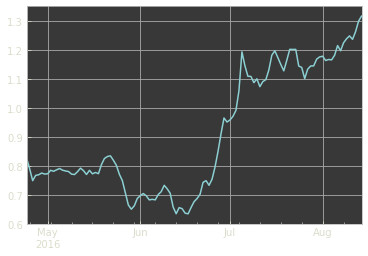

In [6]:
values_buyhold, cap_down = backtest(buy_and_hold, slices_1d[0])
values_buyhold.plot()

Looks good! What's the ROI?

In [7]:
def roi_of (values_df, caps_df):
    ending_value = values_df.iloc[-1]
    ending_cap = caps_df.iloc[-1].values[0]
    return (ending_value - ending_cap) / ending_cap

roi_of(values_buyhold, cap_down)

0.44153196657291682

44.15%. Not bad at all! But, we could have gotten lucky.

Let's find the ROI of this strategy across all 16-week slices of our corpus.

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,

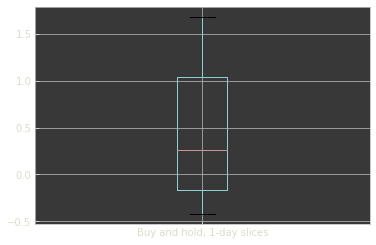

In [8]:
def return_of (strategy, aligned_prices, **kwargs):
    values, caps = backtest(strategy, aligned_prices, **kwargs)
    return roi_of(values, caps)

def returns_across (strat, aligned_price_dfs, name, verbose=True, **kwargs):
    rois = []
    for i, ps in enumerate(aligned_price_dfs):
        if verbose:
            print(i,end=',')
            roi = return_of(strat, ps, **kwargs)
            rois.append(roi)
    s = pd.Series(rois, name=name)
    return s

rois_buy_hold_1d = returns_across(buy_and_hold, slices_1d, 'Buy and hold, 1-day slices')
rois_buy_hold_1d.plot.box()

Overall, our performance is quite good. When we buy and hold, there are some 16-week periods where we end up with a very low return of -50%. But, there are some 16-week periods where our returns are incredible. In fact, the median return (~50%) is pretty damn incredible by itself.

# 3. Improving on buy-and-hold

While our buy-and-hold performance is quite good, it would be nice of we could increase that bottom end of negative returns. 

Improving our top-end of positive returns is ambitious, but that would, of course, also be nice.

Let's look through our data for obvious optimizations.

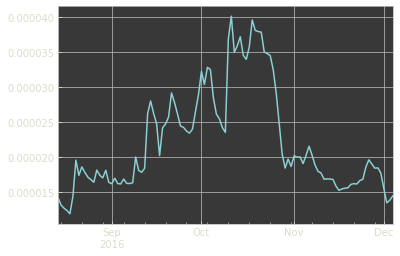

In [56]:
coin_id = 20 # Tweak this
slice_id = 8 # And this
ex_coin = slices_1d[slice_id].iloc[:, coin_id]
ex_coin.plot()

Coins will often spike suddenly, sometimes dropping somewhat (or a lot) in value afterward.

If we could ride these peaks, then exit when the coin starts to crash, we could probably do a lot better than with our buy-and-hold strategy.

To find these peaks, and crashes, we can use a momentum indicator called the [Percentage Price Oscillator (PPO)](http://www.investopedia.com/terms/p/ppo.asp).

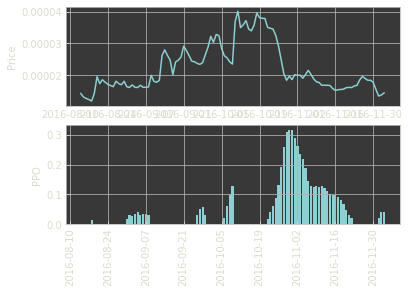

In [57]:
# PandasSeries -> (PandasSeries, PandasSeries)
def emas (price_series, shortw=2, longw=25, **kwargs):
    long_ema  = price_series.ewm(com=longw).mean()
    short_ema = price_series.ewm(com=shortw).mean()
    return long_ema, short_ema

def percentage_price_oscillator (price_series, **kwargs):
    longe, shorte = emas(price_series, **kwargs)
    ppo           = (shorte - longe) / longe
    return ppo

# PandasSeries -> PandasSeries
def ppo_histogram (price_series, **kwargs):
    ppo           = percentage_price_oscillator(price_series)
    ppo_ema       = ppo.ewm(com=9).mean()
    ppo_hist      = pd.DataFrame(ppo - ppo_ema)
    return ppo_hist

# PandasSeries -> PandasSeries
def sell_signal (price_series, ppo_thresh=-0.01, **kwargs):
    ppo_hist = ppo_histogram(price_series, **kwargs)
    sell_signal = ppo_hist[ppo_hist < ppo_thresh].abs()
    return sell_signal

def visualize_sell_signals (price_series, **kwargs):
    s_signal = sell_signal(price_series, **kwargs)
    ax1 = plt.subplot(211)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',)      # ticks along the bottom edge are off
    plt.ylabel('Price')
    plt.plot(price_series.index, price_series.values)
    ax2 = plt.subplot(212, sharex=ax1)
    plt.bar(price_series.index, s_signal.values)
    plt.ylabel('PPO')
    plt.xticks(rotation=90)

visualize_sell_signals(ex_coin)

Let's see how well this performs in practice, by determing when it would catch a real, observed crash. 

True

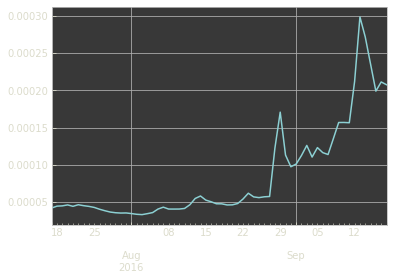

In [87]:
def is_crashing (price_hist, **kwargs):
    '''
    Returns a True if a sell is recommended, given the price history and parameters.
    See `sell_signal() for keyword arguments.
    '''
    signal = sell_signal(price_hist, **kwargs)
    return signal.iloc[-1][0] > 0

catch_i = -49
c = slices_1d[6].iloc[:catch_i, 0]
c.plot()
is_crashing(c)

> **NOTE**: We have encountered our first tunable parameters here. `ppo_thresh`, `shortw` and `longw` are all tweakable. The defaults here are empirically derived (i.e., I did a limited parameter serach and picked some optimal values). These can be contested and tweaked further with more detailed simulations. Feel free to take this challenge on for future work!
Some interesting patterns here.

For one thing, the big drops do look like they get picked up by the signal.
However, so do small drops.

In practice, we may or may not care about these drops. 
It all depends on how much our portfolio rides on that particular coin value.

So, to disambiguate when we should *really* sell,
 we need to figure out which crashes are really consequential for us.
 To determine that, we need to know when a particular asset has sufficient weight in the overall context of our portfolio.


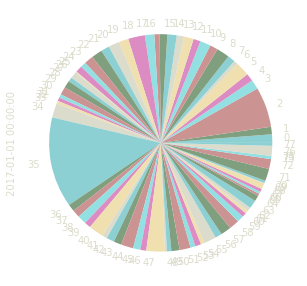

In [12]:
vs, caps, holds, prices, ex_portf_values = backtest(buy_and_hold, slices_1d[10], 
                                                    debug=True)

ex_portf_holdings  = holds.iloc[-1]
ex_portf_prices    = prices.iloc[-1]
ex_portf_values     = ex_portf_values.iloc[-1]
total = sum(ex_portf_values)
proportion = lambda x: x/total
ex_portf_values.apply(proportion).plot.pie(figsize=(5,5))

How do we quantify the undue influence of 35?

Using standard deviation is tempting, but are the values normally distributed?

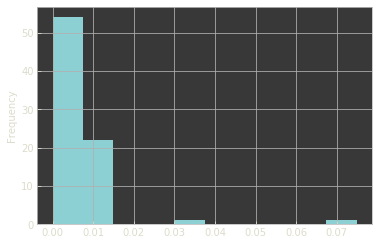

In [13]:
ex_portf_values.plot.hist()

No, not at all - more like a power law distribution.

We can write a method `buffed` to find those coins whose value is more than some `power_of` the median value of coins in the portfolio.

In [14]:
# DataFrame -> DataFrame
def buffed (holding_values, power_of=1.8, **kwargs):
    '''
    Takes a pandas DataFrame with the fiat currency value
    of each security in the portfolio.

    Returns a dataframe with the index, and values, for each ``buffed'' security.

    We consider a `buffed` asset to be valued at a `power_of` the median asset.
    (1.8 is an empirically-derived default).
    '''
    cntr = holding_values.dropna().median()
    if np.isnan(cntr):
        return pd.Series([])
    elif cntr >= 1 or cntr == 0:
        powr = pow(cntr, power_of)
    elif cntr > 0 and cntr < 1:
        powr = pow(cntr, 1/power_of)
    return holding_values[holding_values > powr]

buffed(ex_portf_values)

35    0.074961
Name: 2017-01-01 00:00:00, dtype: float64

> **NOTE** Again, this `power_of` value is totally empirically derived. Tweak away!

# 4. PeakRder

In the above section, we learned that coins can sometimes become overpowered when they spike, or quickly gain in value. Those "buffed" assets can just as easily burst, of course. We can detect these bursts using a low-pass filter on the PPO (percentage price oscillator).

Let's use these observations to try a *slightly* optimized buy-and-hold strategy:

- As before, we invest equally in all coins on Poloniex.
- When a coin becomes "buffed" (more than the median value raised to the 1.2 power), we check to see if it is currently crashing.
- If a buffed asset is currently crashing, we sell the dividends such that its remaining value equals the median value of all holdings in the portfolio. We use the gains from this sale to re-invest equally in all holdings in the portfolio.

In [15]:
# Int, DataFrame, DataFrame -> Float
def rebalance_amount (i, holdings, holding_prices, holding_values):
    '''
    Returns the number of shares of holding `i`
    to sell in order for holding `i` to have
    the same value as the median security in the portfolio.
    '''
    med = holding_values.dropna().median() 
    holding = holdings[i]
    should_hold = med / holding_prices[i]
    return holding - should_hold

rebalance_amount(17, ex_portf_holdings, ex_portf_prices, ex_portf_values)

491.82455232908001

In [88]:
def rebalance_holdings (i, holdings, holding_prices, holding_values,
                        trading_fee=0.0025):
    '''
    Takes the index `i` of a security to rebalance.
    That security is represented in two aligned DataFrames,
    one as the current held number of shares in `holdings`,
    one as the current value of each holding (in fiat currency), `holding_values`.

    Returns a new DataFrame representing the new holdings.
    '''
    
    def subtract_fee (val):
        return val - (val*trading_fee)
    
    def net_gains (shares_sold, price):
        gross = shares_sold * price
        net   = subtract_fee(gross)
        return net
    
    def allocation_per_asset (shares_sold, price):
        net = net_gains(shares_sold, price)
        # spread net equally among each asset in the portfolio, except for this one
        allocation_per_asset =  net / (len(holdings)-1)
        return subtract_fee(allocation_per_asset)
        
    new_holdings = holdings.copy()
    # how many holdings of i to sell?
    shares_to_sell = rebalance_amount(i, holdings, holding_prices, holding_values)
    # sell n holdings of i (taking trading fee)
    new_holdings[i] = holdings[i] - shares_to_sell
    alloc = allocation_per_asset(shares_to_sell, holding_prices[i])
    other_holdings = set(range(len(holdings))) - set([i])
    for holding_i in list(other_holdings):
        shares_to_buy = alloc / holding_prices[holding_i]
        new_holdings[holding_i] = holdings[holding_i] + shares_to_buy
    return new_holdings

rebalanced = rebalance_holdings(35, ex_portf_holdings, ex_portf_prices, ex_portf_values)
# what's the toal portfolio value, before and after rebalance?
total_val = lambda holdings: mult(pd.DataFrame(ex_portf_prices),
                                  pd.DataFrame(holdings)).sum().values[0]
# it should be slightly lower after rebalance than before, due to fees
total_val(ex_portf_holdings) > total_val(rebalanced)

True

In [89]:
# Get a coin's history until `time`
# IRL, this would call some Poloniex API.
# But we'll juse use our pre-scraped data for now.
def get_hist_until (time, coin):
    hist = aligned[coin].dropna()
    return hist[hist.index <= time]

some_col = slices_1d[0].columns[0]
get_hist_until('2016-04-27', some_col).tail()

2016-04-26 23:00:00    0.000043
2016-04-26 23:15:00    0.000043
2016-04-26 23:30:00    0.000043
2016-04-26 23:45:00    0.000041
2016-04-27 00:00:00    0.000041
Name: weightedAverage, dtype: float64

Now, let's write the PeakRider strategy.

PeakRider is substantially the same as our buy-and-hold strategy, except that we occasionally rebalance the portfolio. So, we will treat it as buy-and-hold's `rebalancer`. It will take new prices, and current holdings, and return a new set of holdings, if need be.

In [18]:
# Returns a series `holdings`
def PeakRider_rebalancer (prices, holdings, **kwargs):
    # before buying anyting new, let's check what we already have
    # first, we will estimate the current values of each holding,
    # by multiplying the number coins we have against their current prices
    values = (prices * holdings)
    # we will find any of these holding values that are "buffed" (overly influential)
    bfd = buffed(values, **kwargs)
    for buffed_asset in bfd.keys():
        # for each one, let's check if it is currently crashing.
        # first, we'll grab its history up until this point
        turn_time = prices.name
        hist = get_hist_until(turn_time, buffed_asset)
        # then we'll use that history to see if it is currently crashing
        currently_crashing = is_crashing(hist, **kwargs)
        # now, if this buffed asset is currently crashing, 
        if currently_crashing:
            before =  values.sum()
            # we will use dividents from this asset to rebalance our holdings (`current_turn_holdings`)
            buffed_idx = values.index.get_loc(buffed_asset)
            new_holdings = rebalance_holdings(buffed_idx, holdings, prices, values)
            after =  (prices*new_holdings).sum()
            return new_holdings
    # otherwise
    return holdings

PeakRider = partial(buy_and_hold, rebalancer=PeakRider_rebalancer)


We can visualize its performance on our first, 16-week slice.

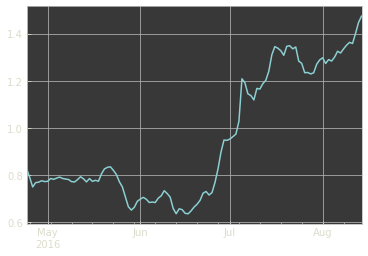

In [19]:
vs, caps = backtest(PeakRider, slices_1d[0])
vs.plot()

Looks good.........what's our ROI?

In [20]:
roi_of(vs, caps)

0.61513638439216978

What would it have been with a buy-and-hold?

In [21]:
vs_bh, caps_bh = backtest(buy_and_hold, slices_1d[0])
roi_of(vs_bh, caps_bh)

0.44153196657291682

Looks better, but, to sanity check, let's test this strategy across all slices in our corpus.
*(This might take a few minutes)*.

In [22]:
rois_peakrider_1d = returns_across(PeakRider, slices_1d, 'PeakRider, 1-day slices')

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,

worst performance: -0.447051669962


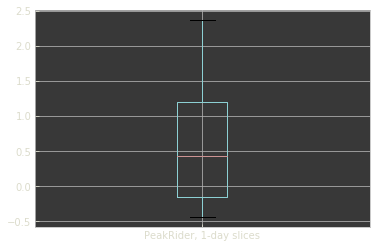

In [25]:
rois_peakrider_1d.plot.box()
print('worst performance:', rois_peakrider_1d.min())

This strategy indeed increases the low-end performance from -50% to "only" -44% in our training set. It also *drastically* increases the median and maximum, to 50% and 250%, respectively. And that 75% percentile that's over 100% return sure looks nice, too.

# 5. High(er) frequency trading

That performance was great, but we were only testing day-by-day. (Imagine running a script every night at midnight to see if there's any trading action to perform).

In our corpus, we have price data down to a 15-minute resolution.
How much better would we have performed if we had traded every 15 minutes?

We have some reason to suspect higher trade frequency can let us eek out an advantage. After all, we rely on catching drops in the market (riding peaks); the earlier we can catch those drops from peaks, the better our returns will be.

In [26]:
import pickle

def save_pickle (thing, path):
    return pickle.dump(thing, open(path, 'wb'))

def load_pickle (path):
    return pickle.load(open(path, 'rb'))

**NOTE: Uncommenting the following cells and running them will take a long time.**. The results are saved as pickles in this repository, so you can load them and examine them later.

If you do want to run this, go out for a walk, take a deep breath, get some time away from the screen.

In [27]:
# rois_peakrider_15m = []
# for i , slc in enumerate(slices_15m):  # Feel free to take a larger subset,
#     print(i, end=',')                       # Or run on all 26.
#     values, caps = backtest(PeakRider, slc) # I am resource-constrained on my laptop.
#     roi = roi_of(values, caps)
#     rois_peakrider_15m.append(roi)
#     save_pickle(values, 'pickles/values_peakrider_15m-{!s}'.format(i))
# save_pickle(rois_peakrider_15m, 'pickles/rois_peakrider_15m')

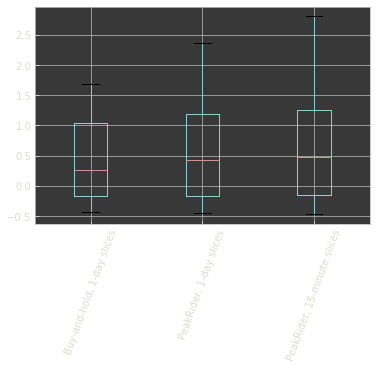

In [90]:
rois_peakrider_15m = pd.Series(load_pickle('pickles/rois_peakrider_15m'))
perfs = pd.DataFrame({
    'Buy-and-hold, 1-day slices':rois_buy_hold_1d,  
    'PeakRider, 1-day slices':rois_peakrider_1d, 
    'PeakRider, 15-minute slices':rois_peakrider_15m, 
})

perfs.plot.box(rot=70)

While our minimum performance, and even our 25th quartile performance is about the same across all of these strategies, our 15-minute PeakRider has the higest mean, 75th quartile, and by far the best maximum return (>250%!).

The question remaining is: are these returns worth the risk of the -50% downside?

# 6. Risk-adjusted returns

So far, we've seen a boxplot with some incredibly high ranges. Yes, the median returns are incredible (more than 50%)! But, the downturn is about as low.

So, a classic question: is the reward worth the risk?

To start evaluating this question, let's look at a fund that is (in some ways) comprable to ours:  Vanguard's Total Stock Market Index Fund (VTSAX).
Like PeakRider, this mutual fund tracks the overall performance of a diverse class of assets in the US stock-market, perhaps with some optimizations on a buy-and-hold strategy.
Like PeakRider, VTSAX functions under the assumption that the US stock market is (when you zoom out far enough) a rising boat.

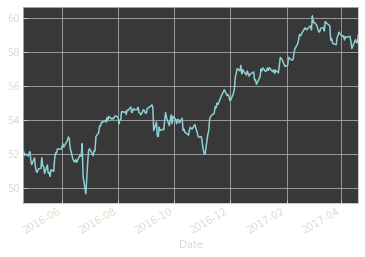

In [31]:
import json
vtsax = pd.read_csv('VTSAX.csv', parse_dates=['Date'], index_col='Date')

def average_price (day):
    return (day['Open'] + day['High'] + day['Low'] + day['Close'])/4

vtsax_prices = vtsax.apply(average_price, axis=1).sort_index()

vtsax_prices.plot()

Out of idle curiosity, how would PeakRider have done over the same period? (We'll start both funds off with the same number of shares).

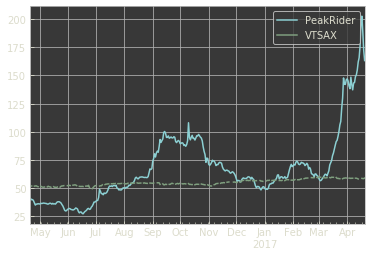

In [121]:
pr_prices, _ = backtest(PeakRider, aligned.resample('1d').mean(), budget=50)
pd.DataFrame({
    'PeakRider': pr_prices,
    'VTSAX': vtsax_prices,
}).plot()

Okay, okay, we would have made a killing. It's easy to hype ourselves up here. 

A better question is, **what are our returns on PeakRider, VTSAX, relative to their risk**? 
To help answer this question, we turn to the concept of [risk-adjusted return](http://www.investopedia.com/terms/r/riskadjustedreturn.asp),
in which we adjust our returns relative to the [risk-free rate](http://www.investopedia.com/terms/r/risk-freerate.asp). Interestingly,

> ...the risk-free rate does not technically exist; even the safest investments carry a very small amount of risk. Thus, investors commonly use the interest rate on a three-month U.S. Treasury bill as a proxy for the risk-free rate because short-term government-issued securities have virtually zero risk of default.

We can set [the 3-month U.S. treasury bill rate](https://ycharts.com/indicators/3_month_t_bill) as a constant:

In [38]:
risk_free_rate = 0.0078

Now, you may already know a few ratios that represent risk-adjusted returns:
the  [Sharpe ratio](http://www.investopedia.com/terms/s/sharperatio.asp),
[Sortino Ratio](http://www.investopedia.com/terms/s/sortinoratio.asp),
and  [Treynor Ratio](http://www.investopedia.com/terms/t/treynorratio.asp)
are all popular ways for calculating risk-adjusted returns.

However, all of these ratios use the standard deviation of returns as part of the calculations. This is great, *iff* the distribution of returns from our fund is normal.

Are they?

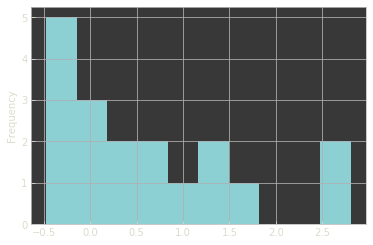

In [33]:
rois_peakrider_15m.plot.hist()

Not even remotely! We have a high positive skew. 

So, what can we use to caluclate our risk-adjusted return?

### [Return Over Maximum DrawDown (RoMaD)](http://www.investopedia.com/terms/r/return-over-maximum-drawdown-romad.asp)

> Drawdown is the difference between a portfolio’s point of maximum return (the “high-water” mark), and any subsequent low point of performance. Maximum drawdown is the largest difference between a high-water and a low.

> RoMaD = Portfolio Return / Max. Drawdown

> If the maximum achieved value for a portfolio to-date was 1,000 and the subsequent minimum level was 900, the maximum drawdown is 10% = [(1000 − 900) / 1000].

This is a great metric in that it doesn't make any claims about the distribution of returns. 
(Look, no standard deviation!).

> **TANGENT**: As we all know, past performance is no guarantee of future performance.  However, past performance may *hint at* some *aspects* of future performance. There's an important difference.  Here, we use past performance to estimate an implied possible risk, based on past performance. With Sharpe and Sortino, we are making a claim about the distrubtion of returns, past *and* future!

>  In contrast, RoMaD makes an empirical observation about past performance.
It does not make claims (even implicitly) about the distribution of returns.
My baseball-stats mind likes this approach very much, as it embraces the essential unpredictability of future conditions. This approach has its limitations, but at least we know where we stand when we use it!

In [34]:
# DataFrame/Series -> Float
def max_drawdown (prices):
    '''
    Drawdown is the difference between a portfolio’s point of maximum return 
    (the “high-water” mark), and any subsequent low point of performance. 
    Maximum drawdown is the largest difference between a high-water and a low.
    
    If the maximum achieved value for a portfolio to-date was 1,000 
    and the subsequent minimum level was 900, 
    the maximum drawdown is 10% [(1000 − 900) / 1000].
    '''
    # if we've recursed all the way to 0,
    # the security's rise is monotonic,
    if (len(prices) is 0):
        # and max drawdown is 0
        return 0
    # otherwise, get the point of highest achieved value
    highest_i = prices.idxmax()
    # and the highest achieved value itself
    peak      = prices[highest_i]
    # now we'll get all closes that occur after this peak
    subsequent_closes = prices.loc[highest_i:]
    # if there are none, 
    if len(subsequent_closes) is 0:
        # we will recurse with the initial values of the list
        initial = prices.loc[:-1]
        return max_drawdown(initial)
    # otherwise, find the subsequent minimum value after this peak
    subsequent_min_i  = prices.idxmin()
    subsequent_min    = prices[subsequent_min_i]
    # and return the maximum drawdown
    return ( peak- subsequent_min) / peak

fund_return = lambda prices: (prices[-1]-prices[0])/prices[0]

def RoMaD (prices):
    '''
    Return over max drawdown.
    '''
    return fund_return(prices) / max_drawdown(prices)

Let's load up the value of our PeakRider fund, for all of the 16-week periods we tested earlier.

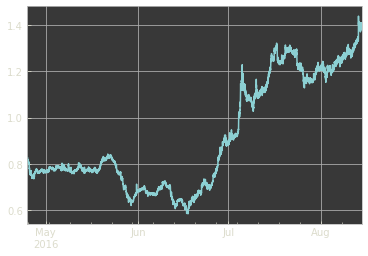

In [98]:
peakrider_prices = [load_pickle('pickles/values_peakrider_15m-{!s}'.format(i)) 
                    for i in range(18)]
peakrider_prices[0].plot()

In [36]:
RoMaD(peakrider_prices[0])

1.1427617982820455

## Sterling ratio

To adjust the RoMaD for the risk-free rate, we can use the
[Sterling ratio](https://en.wikipedia.org/wiki/Sterling_ratio).

Higher is better!

(We'll use 16-week returns instead of annual returns, so we'll adjust the risk-free rate accordingly).

In [49]:
adjusted_risk_free_rate = (risk_free_rate)*(16/52)

# [DataFrame, ...] -> Float
def sterling_ratio (prices, **kwargs):
    '''
    Takes a list of DataFrames, each DataFrame being a list of security prices.
    Returns a Sterling Ratio:
    
       https://en.wikipedia.org/wiki/Sterling_ratio
    '''
    mean_return = np.mean(list(map(fund_return, prices)))
    avg_max_drawdown = np.mean([max_drawdown(price) for price in prices])
    return (mean_return -  adjusted_risk_free_rate) / avg_max_drawdown

sterling_ratio(peakrider_prices)

1.1042113629485615

To make this a super fair comparison, let's timeslice the price of VTSAX the same way we did for our PeakRider data.

In [50]:
vtsax_slices = timeslices(vtsax_prices, weeks_apart=2, week_dur=16)

We can also resample each of our PeakRider prices so that this data is also day-to-day, to match the VTSAX data we have.

In [51]:
peakrider_prices_resampled = [price.resample('1d').mean()
                              for price in peakrider_prices ]

Finally, let's compare PeakRider and VTSAX Sterling ratios.

In [54]:
sterling_ratio(vtsax_slices),  sterling_ratio(peakrider_prices_resampled)

(0.5111810998792794, 1.3043567749173002)

PeakRider's Sterling ratio is more than twice that of VTSAX.

# 7. Caveats I can see

My conclusion, after all of this, is that cryptocurrencies are a rising market. 
We are simply using an optimized buy-and-hold so that our boat will rise with the rising tides.
Yes, the risks are quite significant, the Sterling ratio indicates taht the rewards are beyond commensurate.

That said, I have three major caveats I would like to share:

1. *Selection bias in backtesting*. I only looked at historical data for coins currently traded on Poloniex. What about coins that *were* traded over the past year, but disappeared? Unfortuantely, there is no way for me to find such coins, or even verify that such coins existed. If coins have been removed from Poloniex, then my backtesting data must be highly biased, since it only accounts for those coins successful enough to have stuck around for a year. Future work might address this by digging through different exchanges, or finding other sources of historical data.

2. *Lack of BTC liquidity.* Regardless of a coin's valuation, will we be able to cash our holdings out for Bitcoin (so that we can ultimately convert it to fiat currency)?  I am not convinced that all of the coins in our portfolio have enough Bitcoin backing them to support their supposed market cap. Future work could investigate this, perhaps by accounting for trading volume (which is available to us via the Poloniex API).

3. *Riding peaks, or riding a bubble*? Clearly, cryptocurrency is rising. But, is it a bubble? Will it pop? Unfortunately, timing markets is notoriously hard. However, future work could simulate a catastrophic failure (huge, correlated downturns across all currencies), and simulate various trading strategies that would remove us from the market overall (by transferring to BTC/ETH, then to USD) in a variety of "doomsday" scenarios.

# 8. Future work

- *Improving the downside*. Our poorest performance is quite poor. Can we increase this by being smarter about selling? Or smarter about selecting, or apportioning to different coins? Perhaps we could weight investments toward coins with good historic returns?
- *Lending*. Poloniex allows users to lend to margin traders. There is even [a bot to lend for you](https://github.com/Mikadily/poloniexlendingbot). This could provide returns on otherwise-static investments. What kind of APY to expect, and what kind of risk we take on by lending, should be explored. 
- *Better technical infrastructure*. Ideally, we should collect a timeseries of every trade that happens on Poloniex, so we can perform the highest-resolution possible backtesting. [InfluxDB](https://github.com/influxdata/influxdb) was suggested, along with [Grafana](https://grafana.com/) for analytics. I am open to suggestions. But, I like the idea of an append-only, read-and-create DB for our usecase.

I also want to know what future work you're interested in. Share any ideas over the mailing list.

Also, it goes without saying, but this notebook covers only the technical analysis associated with maximizing our capital accrual. I aspire to much more with this fund. Please stay tuned for more. Thank you for joining me as a partner on what I am sure will be an interesting journey.


# Appendix

Here is where I will keep open questions with no solutions.

## Weak performers

When stuff goes wrong, what goes wrong?

In [104]:
below_0_roi = [price for price in peakrider_prices if fund_return(price)<0]
len(below_0_roi)

6

In [119]:
# When are these from?
each = lambda dfs, i: [df.index[0] for df in dfs]
first_time = lambda dfs: min(each(dfs, 0))
last_time = lambda dfs: max(each(dfs, -1))
first_time(below_0_roi), last_time(below_0_roi)

(Timestamp('2016-09-11 14:45:00'), Timestamp('2016-11-20 14:45:00'))

All 6 of the downturns happened within this 2.5-month period.
What happened during this time? What went wrong?